TO FINISH
- remove query encoding
- Gemini 2.0
- set SubGraphs=False
- improve system instructions

## Build an Agentic Workflow for your BigQuery data with LangGraph and Gemini

### Overview

This notebook shows you how to build an agent-powered workflow with LangGraph to query structured data using natural language.  This example uses BigQuery, but the approach is easily adaptable to other data sources. [Check out the accompanying blog for more context.](https://medium.com/p/947d0a951a45/edit)

The code in this notebook is also used as a base to explore evaluating agentic-workflows and for creating multi-agent workflows: *link*.

### Get Set Up

#### Install and import required packages

In [114]:
# %%capture --no-stderr
# %pip install -U langchain_google_vertexai langgraph google-cloud-aiplatform

In [115]:
import json
import uuid
from typing import Annotated, Dict, Optional

from pydantic import BaseModel, Field

from google.cloud import bigquery

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from langchain_core.tools import tool
from langchain_google_vertexai import ChatVertexAI

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
from typing_extensions import TypedDict

#### Set up Google Cloud (only required if you want to use BigQuery and Gemini)

Authenticate for Colab

In [116]:
#from google.colab import auth
#auth.authenticate_user()

Authenticate for local instance

In [117]:
# ! gcloud auth login

Set your Google Cloud Project ID, BigQuery Dataset ID and Google Cloud Region - this is only required only if you want to use BigQuery as your data source.

In [118]:
PROJECT_ID = "rach-ai"
DATASET_NAME = "choc_ai_test"
DATASET_ID = f"{PROJECT_ID}.{DATASET_NAME}"
REGION = "US" 

# Set the project id
! gcloud config set project {PROJECT_ID}
     

Updated property [core/project].


Upload sample data from GCS to BigQuery. A small dataset is being used to limit the impact of any unexpected queries.
We will use a subset of the chocolate-ai dataset, which has information on customer orders from the ficticious  chocolate store X.

In [119]:
from google.cloud.exceptions import NotFound

client = bigquery.Client()

dataset = bigquery.Dataset(DATASET_ID)
dataset.location = REGION
client.create_dataset(dataset, exists_ok=True)

tables = ["menu", "order", "order_item"]

for table in tables:
    table_id = f"{DATASET_ID}.{table}"
    uri = f"gs://choc_ai_dataset/{table}.csv"

    try:
        client.get_table(table_id)  # Check if table exists
        print(f"Table {table_id} already exists. Skipping load.")
        continue  # Skip to the next table
    
    except NotFound:
        load_job = client.load_table_from_uri(
            uri, table_id, job_config=bigquery.LoadJobConfig(
            autodetect=True, source_format=bigquery.SourceFormat.CSV
        ))    
        load_job.result() 
        destination_table = client.get_table(table_id)
        print("Loaded {} rows.".format(destination_table.num_rows))

Table rach-ai.choc_ai_test.menu already exists. Skipping load.
Table rach-ai.choc_ai_test.order already exists. Skipping load.
Table rach-ai.choc_ai_test.order_item already exists. Skipping load.


#### Helper Functions

These helper functions will be utilized as part of the workflow, but aren't explicitly represented as Tools or Nodes.

In [120]:
def get_schema() -> str: 
    """Retrieves and caches the BigQuery schema for the specified dataset."""
 
    client = bigquery.Client()
    schemas = []
    tables = client.list_tables(DATASET_ID)
    
    for table in tables:      
        table_id = f"{table.project}.{table.dataset_id}.{table.table_id}" 
        table_obj = client.get_table(table_id)
        schema = [field.to_api_repr() for field in table_obj.schema]
        schemas.append({"table_name": table_id, "schema": schema})

    return json.dumps({"tables": schemas}, indent=2)   

### Define your Tools

Define tools that the agent can use to complete its objective.

A note on `SubmitFinalAnswer` - this is a tool that is called once the workflow is finished. It represents the end state. It's not stricly necessary, but it has a few benefits, especially for more complex workflows or those with multiple agents - it standardizes output and provides a clear signal that the workflow is complete (preventing the agent from getting stuck in a loop). It also makes evaluation easier as you can easily identify the final answer produced by the agent. 

In [121]:
@tool
def execute_query_tool(query: str) -> str:
    """Execute a SQL query against BigQuery and return the results as a JSON string."""

    #get rid of this.
    clean_query = query.encode('utf-8').decode('unicode_escape').strip()
    
    # Prevent very basic SQL injection. parameterization ideal here.
    if not clean_query.upper().startswith("SELECT"):
      return json.dumps({"error": "Invalid Query: Only SELECT queries are allowed."})

    if any(keyword in clean_query.upper() for keyword in ["DELETE", "INSERT", "UPDATE", "DROP", "ALTER", "CREATE", "TRUNCATE"]):
      return json.dumps({"error": "Invalid Query: Only SELECT queries are allowed."})
    
    client = bigquery.Client()
    try:
      result = client.query_and_wait(clean_query)
      r = [dict(row) for row in result]
      return str(json.dumps(str(r)))
    except Exception as e:
      error_message = f"BigQuery Error: {str(e)}"
      return json.dumps({"BigQuery error": error_message})

class SubmitFinalAnswer(BaseModel):
    """Represents the final answer submitted by the agent."""

    final_answer: str = Field(..., description="The final answer to submit to the user")


### Initialize your LLMs and assign them tools

Create a base LLM object using the `ChatVertexAI` class with the Gemini model. Bind the tools defined above to the LLM so that the LLM can use them as needed.

In [122]:
MODEL = "gemini-1.5-flash"
#MODEL = "gemini-2.0-flash-exp"

data_llm_with_tools = ChatVertexAI(model=MODEL).bind_tools([execute_query_tool, SubmitFinalAnswer])

### Memory and State

The `State` consists of the schema of the graph (not to be confused with the dataset_schemas below) as well as reducer functions which specify how to apply updates to the state. It represents the current snapshot of your application. The state is passed as an argument to each node in your LangGraph workflow, allowing nodes to read from and update the state as needed. This enables different parts of your workflow to share information and coordinate their actions.

The `add_messages` reducer function in our State will append an LLM's response messages to whatever messages are already in the state (rather than overwriting them).

In [123]:
class State(TypedDict):
    """Defines the LangGraph workflow state."""

    messages: Annotated[list[AnyMessage], add_messages]
    dataset_schema: Optional[str]


State is considered short-term memory and is scoped to a particular thread (a specific instance of your LangGraph workflow - like a single user interaction).


Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions, or graph runs.

If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off. This is known as persistent checkpointing.

Long-term memory is shared across conversational threads. It can be recalled at any time and in any thread....

In [124]:
memory = MemorySaver()

### Create nodes for your graph


Nodes are the fundamental building blocks of a LangGraph workflow. They represent individual units of work or processing steps. Each node is a function that takes the current state dictionary as input, performs its task, and returns a modified state dictionary. This modified state is then passed to the next node in the workflow based on the connections defined in the graph.
This is the basic pattern for all LangGraph node functions.

`get_schema_node`: This node retrieves and stores the database schema in the state if it's not already present. This ensures the schema is fetched only once.

`data_chatbot_node`: This node uses an LLM to understand user requests (the prompt). Guided by its system instructions and the schema, it will generate a SQL query and use the tools at its disposal to execute this query in BigQuery.

`get_state`: This node controls the workflow's transitions. It checks the last message in the conversation to decide whether to call a tool, the data_chatbot node, or end the workflow altogether.

In [ ]:
sys_message = """You are an expert at understading user requirements and translating them into valid BigQuery SQL. Your job is to:

1. Understand the user's data requirements for their data. They can ask questions about the tables and schema, or try to get insights from the data itself.
2. Validate the feasibility of their request using the schema. Inform the user if their request is not feasible and offer alternative suggestions based on the schema.
3. Generate a valid BigQuery SQL query that directly answers the user's question.  Use the schema to infer relationships between tables, including primary and foreign keys.
4. Execute the generated SQL query using the `execute_query_tool`.
5. Once the have the results from the execute_query_tool, you must ALWAYS call the `SubmitFinalAnswer` tool to present these to the user as the final answer and then end the workflow.

Crucial Guidelines:

* Schema: You will use the following schema for all data queries: {schema}
* SQL Generation:
    * Create the SQL query that directly answers the input question. The query must conform to the schema. Do not make any tool calls within the SQL generation step.
    * Meaningful Column Names: Ensure any new result columns have meaningful names.
    * Result Limits: Unless the user specifies a different number, limit your query to at most 5 results. Order results by a relevant column to prioritize the most informative examples.
    * Column Selection: Never query for all columns from a table. Only request the relevant columns based on the user's question.
    * Valid SQL: The generated SQL *must* be valid BigQuery SQL that can be executed directly without any modifications or encoding. Do *not* include escape characters. 
        For example: "SELECT * FROM `choc_ai.menu`, not: SELECT\\\\n    *\\\\n  FROM\\\\n    `choc_ai.menu`"
    * No DML: Do not generate any Data Manipulation Language (DML) statements (INSERT, UPDATE, DELETE, DROP, etc.).
* Tool Usage:    
    * Use the `execute_query_tool` to execute the generated SQL query.
    * Use the `SubmitFinalAnswer` tool *only* to present the final results to the user and then end the workflow. Do not use it before the query has been executed and results retrieved.  Do not use any other tool.
"""

def get_schema_node(state: Dict) -> Dict:
    """Retrieves the schema from BigQuery and stores it in the state."""
    
    if state.get("dataset_schema") is None: 
        schema = get_schema()  
        return {"dataset_schema": schema, "messages": [AIMessage(content="Schema retrieved from BigQuery")]}
    return {"messages": [AIMessage(content="Schema retrieved from memory")]}

def data_chatbot_node(state: Dict) -> Dict:
    """Extracts user requirements using an LLM."""
    
    schema = state["dataset_schema"]        
    messages = [SystemMessage(content=sys_message.format(schema=schema))] + state["messages"]
    response = data_llm_with_tools.invoke(messages)    
    return {"messages": [response]}
    
def get_state(state: Dict) -> str:
    """Determine the next steps in the workflow."""
    
    last_message = state["messages"][-1]     

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        if any(tool_call["name"] == "execute_query_tool" for tool_call in last_message.tool_calls):
            return "execute_sql"      

    if not isinstance(last_message, HumanMessage):
        return END

    return "data_chatbot"

### Define your graph

Define the structure of the agent's workflow using `StateGraph(State)` - this represents the workflow as a directed graph.

Next, add the nodes defined above to the StateGraph, these are like individual steps in your workflow. 
The `START` node specifies the entry point - this tells our graph where to start its work each time we run it.
Similarly, the `END` node instructs the graph the end the workflow when this node is run. When the workflow reaches the `END` node, it means that the user's input has been processed, and they are now free to provide another.

You can then add your edges, which define the order of these steps. Conditional edges execute functions to determine which node is next.

In [126]:
workflow = StateGraph(State)

workflow.add_node("get_schema", get_schema_node)
workflow.add_node("data_chatbot", data_chatbot_node)
workflow.add_node("execute_sql", ToolNode([execute_query_tool]))

workflow.add_edge(START, "get_schema")
workflow.add_edge("get_schema", "data_chatbot")
workflow.add_conditional_edges("data_chatbot", get_state, ["execute_sql", "data_chatbot", END]) 
workflow.add_edge("execute_sql", "data_chatbot")

Compile the workflow into a runnable graph and then visualize its components.

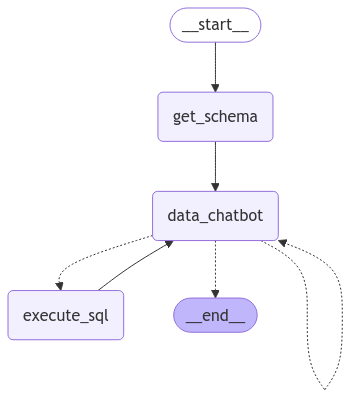

In [127]:
data_chatbot_graph = workflow.compile(checkpointer=memory)

display(Image(data_chatbot_graph.get_graph().draw_mermaid_png()))

### Go agents, go!

Finally, run the graph! 

The config dictionary includes:
-   `thread_id`  if you have provided a checkpointer at compilation time like we have, the thread_id will save the state in memory after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.
- `recursion_limit`  sets the number of supersteps that the graph is allowed to execute before it raises an error.

The `data_chatbot_graph.stream` method streams back outputs from a graph run. You can stream a graph in different modes (values, updates, debug) depending on how much information you want returned. 

In [128]:
config = {"configurable": {"thread_id": "101"}, "recursion_limit": 20}

while True:    
    user = input("User (q/Q to quit): ")

    if user in {"q", "Q"}:
        break
    output = None
    for output in data_chatbot_graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, subgraphs=True, stream_mode="values"
    ):
        output[-1]["messages"][-1].pretty_print()

In [129]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}, "recursion_limit": 20}
#user_input = "What columns are in the menu table, and what do they represent?"
#user_input = "What is the most expensive item on the menu? Don't include any items that start with F"
#user_input = "Generate a report based on the sales in August, comparing the best and worst performing products"
user_input = "How many rows are there in the menu table?"
#user_input = "describe this dataset in one sentence"
user_input = "Which product had the most sales in August?"
output = None
for output in data_chatbot_graph.stream(
    {"messages": [HumanMessage(content=user_input)]},
    config=config, subgraphs=True, stream_mode="values"
):
    try:
        #content = next(iter(output[-1].values())).get("messages")
        output[-1]["messages"][-1].pretty_print()
    except (KeyError, IndexError):
        print("Error: Unexpected LLM response format.  'messages' key missing or empty list.")
        # Add appropriate recovery logic here (e.g., log the error, skip the iteration, or try a different approach).
        continue #Skip to the next iteration of the loop

================================ Human Message =================================

Which product had the most sales in August?


================================== Ai Message ==================================

Schema retrieved from BigQuery
================================== Ai Message ==================================

```json
{
 "tables": [
  {
   "table_name": "rach-ai.choc_ai_test.menu",
   "schema": [
    {
     "name": "menu_id",
     "type": "INTEGER",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_name",
     "type": "STRING",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_description",
     "type": "STRING",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_size",
     "type": "STRING",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_price",
     "type": "FLOAT",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_allergy_info",
     "type": "STRING",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_image_gcs_filename",
     "type": "STRING",
     "mode": "NULLABLE"
    },
    {
     "name": "menu_image_http_url",
     "type": "STRING",
     "mode": "NULLABLE